## Image segmentation

In [ ]:
!nvidia-smi

Fri Apr 11 19:06:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
from google.colab import drive
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2DTranspose, Concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


## Download Data from Github


In [ ]:
!git clone https://github.com/mvaldenegro/marine-debris-fls-datasets.git

Cloning into 'marine-debris-fls-datasets'...
remote: Enumerating objects: 20432, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 20432 (delta 0), reused 0 (delta 0), pack-reused 20431 (from 2)
Receiving objects: 100% (20432/20432), 1.36 GiB | 7.02 MiB/s, done.
Resolving deltas: 100% (2170/2170), done.
Updating files: 100% (20131/20131), done.


#Download Data from GoogleDrive


In [ ]:
from google.colab import drive
import shutil

# Monter Google Drive
drive.mount('/content/drive')

# Définir le chemin du dossier sur Google Drive
drive_folder = "/content/drive/my-drive/data_mask"  # Remplace avec ton dossier

# Définir le chemin de destination dans l'environnement Colab
colab_folder = "/content/data_mask"

# Copier le dossier de Drive vers Colab
if os.path.exists(drive_folder):
    shutil.copytree(drive_folder, colab_folder)

Mounted at /content/drive


##Verification of image/mask pairs

---



In [ ]:
# Chemins des dossiers (à adapter)
images_dir = '/content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-segmentation/Images/'
masks_dir = '/content/drive/MyDrive/data_mask/'

# Récupération et vérification des fichiers
valid_pairs = []
for img_file in os.listdir(images_dir):
    if img_file.endswith('.png'):
        mask_file = 'mask_' + img_file
        if os.path.exists(os.path.join(masks_dir, mask_file)):
            valid_pairs.append((img_file, mask_file))
        else:
            print(f"Fichier masque manquant pour {img_file} - suppression")

print(f"{len(valid_pairs)} paires valides trouvées")

Fichier masque manquant pour marine-debris-aris3k-97.png - suppression
Fichier masque manquant pour marine-debris-aris3k-918.png - suppression
Fichier masque manquant pour marine-debris-aris3k-995.png - suppression
Fichier masque manquant pour marine-debris-aris3k-975.png - suppression
Fichier masque manquant pour marine-debris-aris3k-933.png - suppression
Fichier masque manquant pour marine-debris-aris3k-90.png - suppression
Fichier masque manquant pour marine-debris-aris3k-949.png - suppression
Fichier masque manquant pour marine-debris-aris3k-796.png - suppression
Fichier masque manquant pour marine-debris-aris3k-806.png - suppression
Fichier masque manquant pour marine-debris-aris3k-779.png - suppression
Fichier masque manquant pour marine-debris-aris3k-776.png - suppression
Fichier masque manquant pour marine-debris-aris3k-976.png - suppression
Fichier masque manquant pour marine-debris-aris3k-822.png - suppression
Fichier masque manquant pour marine-debris-aris3k-895.png - suppre

##Model creation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def enhanced_model(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Modified Conv Block with residual channel matching
    def conv_block(x, filters, use_residual=False):
        x_init = x

        # First convolution
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)

        # Second convolution
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Handle residual connection with channel projection
        if use_residual:
            if x_init.shape[-1] != filters:  # Channel mismatch
                x_init = layers.Conv2D(filters, (1, 1), padding='same')(x_init)
            x = layers.Add()([x_init, x])

        return layers.LeakyReLU(alpha=0.1)(x)

    # Encoder Path
    # Block 1 (32 filters)
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # 64x64

    # Block 2 (64 filters with residual)
    c2 = conv_block(p1, 64, use_residual=True)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # 32x32

    # Block 3 (128 filters with residual)
    c3 = conv_block(p2, 128, use_residual=True)
    p3 = layers.MaxPooling2D((2, 2))(c3)  # 16x16

    # Block 4 (256 filters)
    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2, 2))(c4)  # 8x8

    # Bottleneck with Spatial Dropout
    b = layers.SeparableConv2D(512, (3, 3), padding='same')(p4)
    b = layers.BatchNormalization()(b)
    b = layers.SpatialDropout2D(0.3)(b)
    b = layers.LeakyReLU(alpha=0.1)(b)

    # Decoder Path
    def upsample_block(x, skip, filters):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        return layers.LeakyReLU(alpha=0.1)(x)

    # Up Block 1 (256 filters)
    x = upsample_block(b, c4, 256)
    x = conv_block(x, 256)  # 16x16

    # Up Block 2 (128 filters)
    x = upsample_block(x, c3, 128)
    x = conv_block(x, 128)  # 32x32

    # Up Block 3 (64 filters)
    x = upsample_block(x, c2, 64)
    x = conv_block(x, 64)  # 64x64

    # Up Block 4 (32 filters)
    x = upsample_block(x, c1, 32)
    x = conv_block(x, 32)  # 128x128

    # Output Layer
    outputs = layers.SeparableConv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    return Model(inputs=inputs, outputs=outputs)

# Create and verify the model
model = enhanced_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_4[0][0],   │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ leaky_re_lu_3[0]

 Total params: 5,244,609 (20.01 MB)

 Trainable params: 5,239,745 (19.99 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryIoU(threshold=0.5)]
)

##Split dataset

In [ ]:
# Split train/test/val (80/10/10)
train_pairs, test_val_pairs = train_test_split(valid_pairs, test_size=0.2, random_state=42)
test_pairs, val_pairs = train_test_split(test_val_pairs, test_size=0.5, random_state=42)

print(f"Train: {len(train_pairs)}, Test: {len(test_pairs)}, Val: {len(val_pairs)}")

Train: 1281, Test: 160, Val: 161


## Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, pairs, batch_size=8, target_size=(128, 128)):
        self.pairs = pairs
        self.batch_size = batch_size
        self.target_size = target_size  # Doit être 256x256

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.pairs[idx*self.batch_size:(idx+1)*self.batch_size]
        images, masks = [], []

        for img_file, mask_file in batch:

            # Chargement image (256x256)
            img_path = os.path.join(images_dir, img_file)
            image = tf.keras.preprocessing.image.load_img(img_path, target_size=self.target_size)
            image = tf.keras.preprocessing.image.img_to_array(image)/255.0

            # Chargement masque (256x256)
            mask_path = os.path.join(masks_dir, mask_file)
            mask = tf.keras.preprocessing.image.load_img(mask_path,
                                                         target_size=self.target_size,  # Même taille que l'image
                                                         color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask)
            mask = (mask > 127).astype(np.float32)  # Binarisation directe

            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)
# Création des générateurs
train_gen = DataGenerator(train_pairs, batch_size=8)
val_gen = DataGenerator(val_pairs, batch_size=8)
test_gen = DataGenerator(test_pairs, batch_size=8)

In [ ]:
# Test des dimensions
sample_batch = train_gen[0]
preds = model.predict(sample_batch[0])

print("Input shape:", sample_batch[0].shape)
print("Model output shape:", preds.shape)
print("Mask shape:", sample_batch[1].shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Input shape: (8, 128, 128, 3)
Model output shape: (8, 128, 128, 1)
Mask shape: (8, 128, 128, 1)


##Training

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=4)
    ]
)

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - binary_io_u: 0.6899 - loss: 0.4514 - val_binary_io_u: 0.6079 - val_loss: 0.3043 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - binary_io_u: 0.7200 - loss: 0.1988 - val_binary_io_u: 0.6522 - val_loss: 0.4369 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - binary_io_u: 0.7403 - loss: 0.1439 - val_binary_io_u: 0.6997 - val_loss: 0.2599 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - binary_io_u: 0.7511 - loss: 0.1248 - val_binary_io_u: 0.7235 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - binary_io_u: 0.7707 - loss: 0.1159 - val_binary_io_u: 0.7537 - val_loss: 0.1636 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - binary_io_u: 0.7840 - loss: 0.1080 - val_binary_io_u: 0.7730 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 1

##Results visualization

In [ ]:
print("Clés disponibles dans history:", history.history.keys())

Clés disponibles dans history: dict_keys(['binary_io_u', 'loss', 'val_binary_io_u', 'val_loss', 'learning_rate'])


KeyError: 'binary_io_u_1'

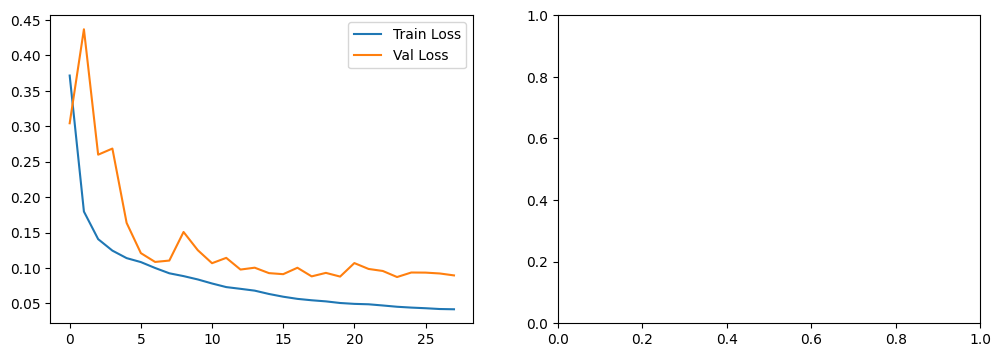

In [ ]:
# Courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_io_u_1'], label='Train IoU')
plt.plot(history.history['val_binary_io_u_1'], label='Val IoU')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from itertools import islice


def plot_predictions(num_samples=3):
    # Récupération des données
    test_iter = iter(test_gen)
    test_iter = islice(test_iter, 3, None)
    images, masks = next(test_iter)
    preds = model.predict(images)

    # Ajustement des dimensions si nécessaire
    if preds.shape[-1] != 1:
        preds = preds.reshape(-1, 128, 128, 1)

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Configuration de l'affichage pour l'image
        if images.shape[-1] == 1:  # Image en niveaux de gris
            img_display = images[i].squeeze()
            cmap_img = 'gray'
        else:
            img_display = images[i]
            cmap_img = None

        # Superposition du vrai masque (rouge semi-transparent)
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img_display, cmap=cmap_img)
        plt.imshow(masks[i].squeeze(), cmap='Reds', alpha=0.5)
        plt.title('Image avec Vrai Masque')
        plt.axis("off")

        # Superposition de la prédiction (bleu semi-transparent)
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(img_display, cmap=cmap_img)
        plt.imshow((preds[i].squeeze() > 0.5), cmap='Blues', alpha=0.5)
        plt.title('Image avec Prédiction')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_predictions()

In [ ]:
test_metrics = model.evaluate(test_gen)
print(f"Test Loss: {test_metrics[0]}, Test IoU: {test_metrics[1]}")

In [ ]:
model.save('/content/model.h5')